<a href="https://colab.research.google.com/github/693080593/research/blob/master/Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression
* object: 
    * Predict ETF in next day using linear regression. Given prices for the last N days, we do prediction for day N+1
    * Find the best N to predict the adjusted close price
    * Get the prediction precision based the rule $R^2$, RMSE and MAPE

In [ ]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Input params ##################
path = "/content/SPY.csv"
test_size = 0.2  # proportion of dataset to be used as test set
cv_size = 0.2  # proportion of dataset to be used as cross-validation set
Nmax = 30  # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
# Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

## Functions for linear regression

In [ ]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(
            df['adj_close'][i - N:i])))  # e.g. [0 1 2 3 4]
        y_train = np.array(
            df['adj_close'][i - N:i])  # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)  # e.g X_train =
        # [[0]
        #  [1]
        #  [2]
        #  [3]
        #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
        #     print X_train.shape
        #     print y_train.shape
        #     print 'X_train = \n' + str(X_train)
        #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)  # Train the model
        num = np.array(N).reshape(-1, 1)
        pred = regr.predict(num)

        pred_list.append(pred[0][0])  # Predict the footfall using the model

    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min

    return pred_list


## Compute mean absolute percentage error (MAPE)
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Loading data

In [ ]:
df = pd.read_csv(path, sep=",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume,month
0,2014-03-31,186.669998,187.300003,185.520004,187.009995,169.368149,99745000,3
1,2014-04-01,187.619995,188.360001,187.000000,188.250000,170.491180,89193000,4
2,2014-04-02,188.490005,189.130005,188.139999,188.880005,171.061722,78774000,4
3,2014-04-03,189.169998,189.220001,188.050003,188.630005,170.835327,77435000,4
4,2014-04-04,189.660004,189.699997,186.100006,186.399994,168.815704,169381000,4
5,2014-04-07,185.949997,186.259995,183.960007,184.339996,166.950043,140803000,4
6,2014-04-08,184.259995,185.399994,183.589996,185.100006,167.638336,112660000,4
7,2014-04-09,185.600006,187.149994,185.059998,187.089996,169.440613,100254000,4
8,2014-04-10,187.080002,187.169998,182.929993,183.160004,165.881363,172959000,4
9,2014-04-11,182.139999,183.419998,181.309998,181.509995,164.387024,167251000,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1259 non-null   datetime64[ns]
 1   open       1259 non-null   float64       
 2   high       1259 non-null   float64       
 3   low        1259 non-null   float64       
 4   close      1259 non-null   float64       
 5   adj_close  1259 non-null   float64       
 6   volume     1259 non-null   int64         
 7   month      1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 88.5 KB


In [ ]:
df.describe()

,open,high,low,close,adj_close,volume,month
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,229.749452,230.744519,228.618133,229.761771,219.240476,9.904178e+07,6.540111
std,31.225691,31.319175,31.100454,31.192640,35.836418,4.879860e+07,3.422864
min,182.139999,183.369995,181.020004,181.509995,164.387024,2.785650e+07,1.000000
25%,204.849998,206.100006,203.959999,204.994996,189.990547,6.653075e+07,4.000000
50%,216.529999,217.119995,215.750000,216.589996,205.805191,8.627080e+07,7.000000
75%,259.970001,261.029999,258.044998,259.794999,255.438476,1.169876e+08,10.000000
max,293.089996,293.940002,291.809998,293.579987,289.286011,5.072443e+08,12.000000


Text(0, 0.5, 'USD')

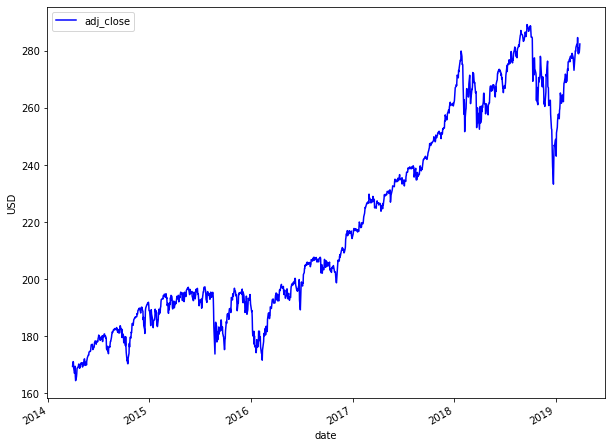

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-')
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Split into training, validation and test set

In [ ]:
# Get sizes of each of the datasets
num_cv = int(cv_size * len(df))
num_test = int(test_size * len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train + num_cv]
train_cv = df[:num_train + num_cv]
test = df[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

print("The time range of validation set is \n" + str(train['date'].min()) +
      "  " + str(train['date'].max()))
print("The time range of validation set is \n" + str(cv['date'].min()) + "  " +
      str(cv['date'].max()))
print("The time range of test set is \n" + str(test['date'].min()) + "  " +
      str(test['date'].max()))

num_train = 757
num_cv = 251
num_test = 251
train.shape = (757, 8)
cv.shape = (251, 8)
train_cv.shape = (1008, 8)
test.shape = (251, 8)
The time range of validation set is 
2014-03-31 00:00:00  2017-03-30 00:00:00
The time range of validation set is 
2017-03-31 00:00:00  2018-03-29 00:00:00
The time range of test set is 
2018-04-02 00:00:00  2019-03-29 00:00:00


## EDA

Text(0, 0.5, 'USD')

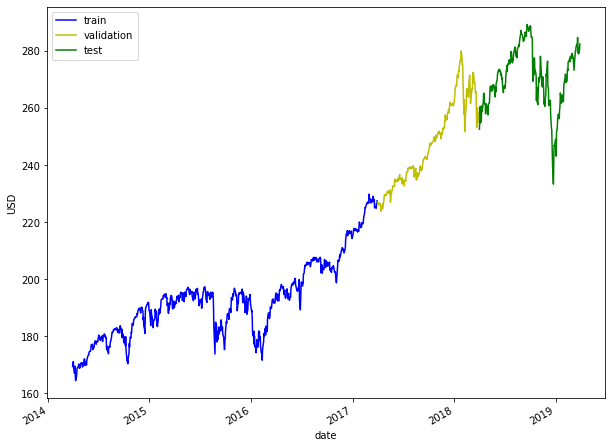

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Predict using Linear Regression

In [ ]:
RMSE = []
R2 = []
mape = []
for N in range(
        1, Nmax + 1):  # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)

    cv['est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [1.856816753102387, 2.621290078542159, 2.508467414295041, 2.245586936062593, 2.1316825348962776, 2.187076242192885, 2.280654163033805, 2.3400710087099514, 2.4316949545990427, 2.5552013898983925, 2.697880479932486, 2.828103607889358, 2.9409482055617757, 3.0503843893391003, 3.142754985089105, 3.217788845020259, 3.2820759921554417, 3.3246657655878584, 3.3543574232380906, 3.387847083927272, 3.4282619831781527, 3.4752598510511565, 3.52860511808197, 3.5888070571217714, 3.6533617334460615, 3.722437899959797, 3.788091032479301, 3.8485367457120065, 3.9092205467429664, 3.9579312490895764]
R2 = [0.9835878498641278, 0.9672917312989477, 0.9700467247768978, 0.9759958055838538, 0.9783692068941765, 0.977230408703148, 0.975240249864345, 0.9739333355332974, 0.9718521273939871, 0.9689202397869474, 0.9653524283801602, 0.9619269191481448, 0.958827983189469, 0.9557068539046103, 0.9529837012494002, 0.9507118550481403, 0.9487227584773736, 0.9473833283883593, 0.9464393223220922, 0.9453644916324272, 0.94

,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,est_N3,est_N4,est_N5,est_N6,est_N7,est_N8,est_N9,est_N10,est_N11,est_N12,est_N13,est_N14,est_N15,est_N16,est_N17,est_N18,est_N19,est_N20,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
757,2017-03-31,235.899994,236.509995,235.679993,235.740005,226.921509,73733100,3,227.450912,228.172851,227.832753,228.375007,228.095841,227.730701,227.371148,227.244637,226.457829,225.950539,225.585750,225.307089,225.460410,225.464480,225.506249,225.656539,225.816365,225.900802,225.903602,225.847933,225.828956,225.692756,225.871838,225.973383,226.091650,226.216680,226.336024,226.424575,226.594241,226.762375
758,2017-04-03,235.800003,236.029999,233.910004,235.330002,226.526855,85546500,4,226.921509,226.392106,227.226334,227.388374,228.004426,227.965588,227.764452,227.507642,227.420168,226.726403,226.248368,225.884555,225.593079,225.699967,225.675935,225.690810,225.811447,225.945858,226.012925,226.004841,225.942128,225.914719,225.775804,225.938520,226.029006,226.136889,226.252560,226.363912,226.446526,226.608252
759,2017-04-04,235.000000,235.580002,234.559998,235.479996,226.671219,56466200,4,226.526855,226.132201,226.042368,226.623123,226.892651,227.520897,227.628328,227.555101,227.395581,227.360445,226.762233,226.330082,225.987113,225.702341,225.784316,225.748005,225.749492,225.852498,225.971467,226.029065,226.016471,225.952090,225.921250,225.783687,225.934887,226.018272,226.119323,226.228800,226.334961,226.414072
760,2017-04-05,236.259995,237.389999,234.539993,234.779999,225.997406,108800600,4,226.671219,226.815583,226.456238,226.209190,226.548024,226.766218,227.325803,227.480497,227.468578,227.364294,227.358693,226.831217,226.434642,226.108674,225.829856,225.890560,225.843342,225.832678,225.919482,226.023885,226.072076,226.054495,225.987736,225.952971,225.815911,225.955834,226.031935,226.125922,226.228905,226.329493
761,2017-04-06,234.940002,236.039993,234.429993,235.440002,226.632736,69135800,4,225.997406,225.323593,225.869044,225.872261,225.766390,226.076989,226.316452,226.861004,227.072310,227.127498,227.086191,227.122478,226.670482,226.320559,226.024651,225.765113,225.819782,225.773791,225.761886,225.842616,225.941305,225.987535,225.971308,225.907746,225.874306,225.742244,225.875950,225.949114,226.040030,226.140171


(2.0, 30.0)

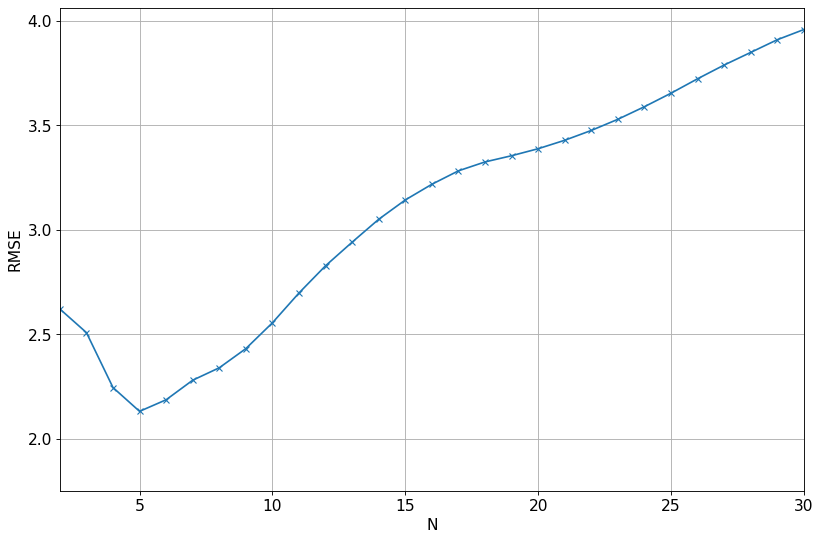

In [ ]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax + 1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, Nmax])

Lowest RMSE is achieved with N=1, followed by N=5

(2.0, 30.0)

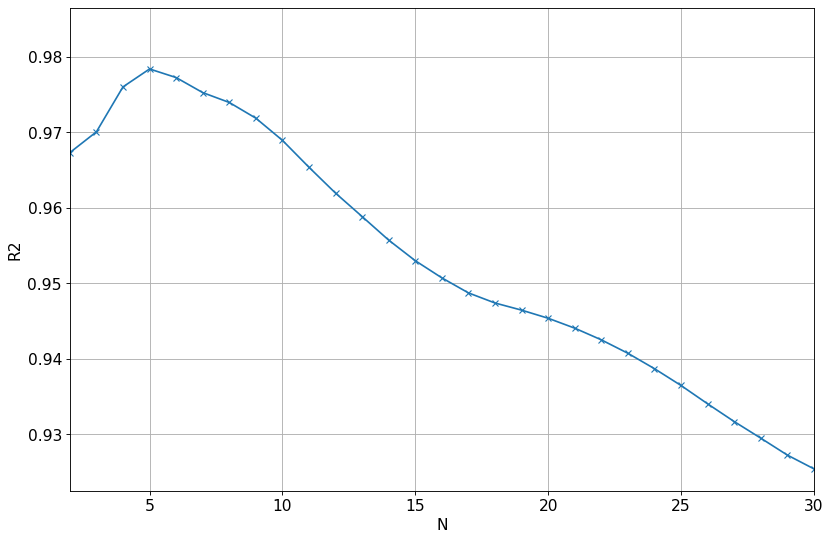

In [ ]:
# Plot R2 versus N. Note for R2 larger better.
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax + 1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')
plt.xlim([2, Nmax])

(2.0, 30.0)

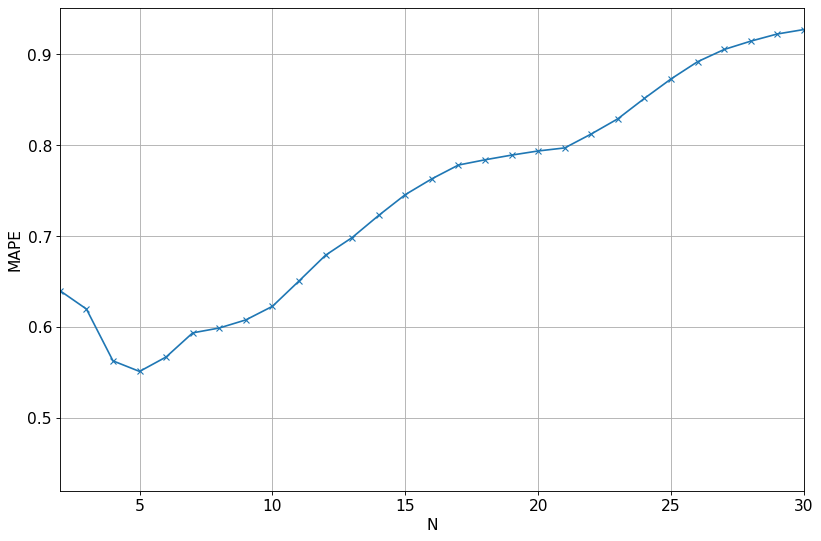

In [ ]:
# Plot MAPE versus N. Note for MAPE smaller better.
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax + 1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, Nmax])

In [ ]:
# Set optimum N
N_opt = 5

## Plot predictions for a specific day

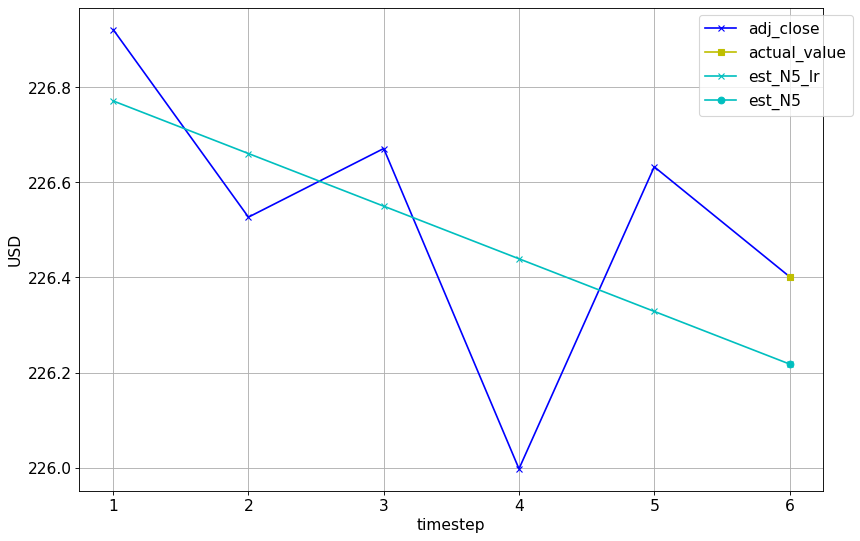

In [ ]:
# Specify the day you are interested in
day = pd.Timestamp(date(2017, 4, 7))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered)
Nmax2 = 5

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax2 + 2), df_temp[-Nmax2 - 1:]['adj_close'], 'bx-')
plt.plot(Nmax2 + 1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True)  # Create linear regression object
for N in range(5, Nmax2 + 1):
    # Plot the linear regression lines
    X_train = np.array(range(len(
        df_temp['adj_close'][-N - 1:-1])))  # e.g. [0 1 2 3 4]
    y_train = np.array(
        df_temp['adj_close'][-N - 1:-1])  # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)  # Train the model
    y_est = regr.predict(X_train)  # Get linear regression line
    plt.plot(
        range(Nmax2 + 1 - N, Nmax2 + 2),
        np.concatenate(
            (y_est, np.array(df_temp['est_N' + str(N)][-1:]).reshape(-1, 1))),
        color=color_list[N % len(color_list)],
        marker=marker_list[N % len(marker_list)])
    legend_list.append('est_N' + str(N) + '_lr')

    # Plot the predictions
    plt.plot(
        Nmax2 + 1,
        df_temp['est_N' + str(N)][-1:],
        color=color_list[N % len(color_list)],
        marker='o')
    legend_list.append('est_N' + str(N))

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

## Plot predictions on validation set

Text(0, 0.5, 'USD')

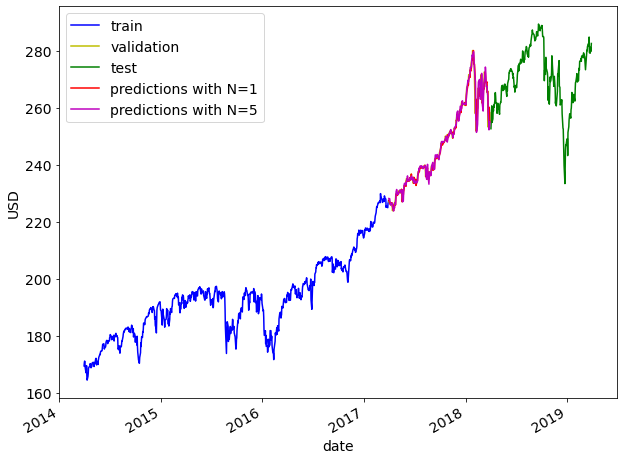

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', ax=ax)
ax.legend([
    'train', 'validation', 'test', 'predictions with N=1',
    'predictions with N=5'
])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to validation set')

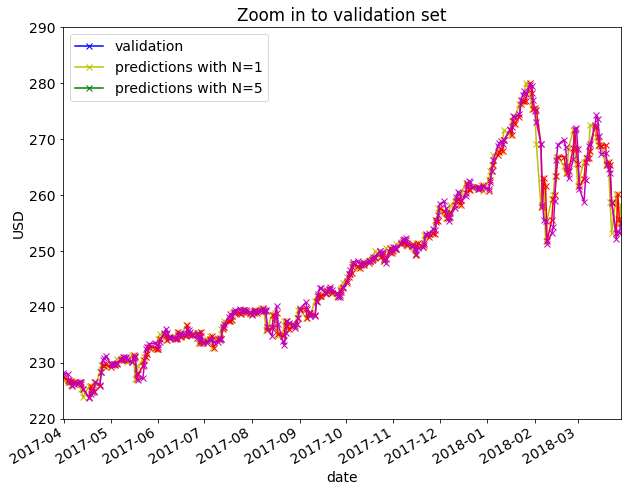

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-')
ax = cv.plot(x='date', y='adj_close', style='yx-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', ax=ax)
ax.legend(['validation', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 31), date(2018, 3, 29)])
ax.set_ylim([220, 290])
ax.set_title('Zoom in to validation set')

## Final model

In [ ]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train + num_cv)
test['est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(
    mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 3.198
R2 = 0.907
MAPE = 0.862%


,date,open,high,low,close,adj_close,volume,month,est_N5
1008,2018-04-02,262.549988,263.130005,254.669998,257.470001,252.570038,186286300,4,257.822127
1009,2018-04-03,258.869995,261.309998,256.839996,260.769989,255.807266,119956900,4,252.514101
1010,2018-04-04,256.750000,264.359985,256.600006,263.559998,258.544128,123715300,4,254.814515
1011,2018-04-05,265.549988,266.640015,264.320007,265.640015,260.584564,82652600,4,257.484715
1012,2018-04-06,263.420013,265.109985,258.000000,259.720001,254.777206,179521200,4,260.387390


Text(0, 0.5, 'USD')

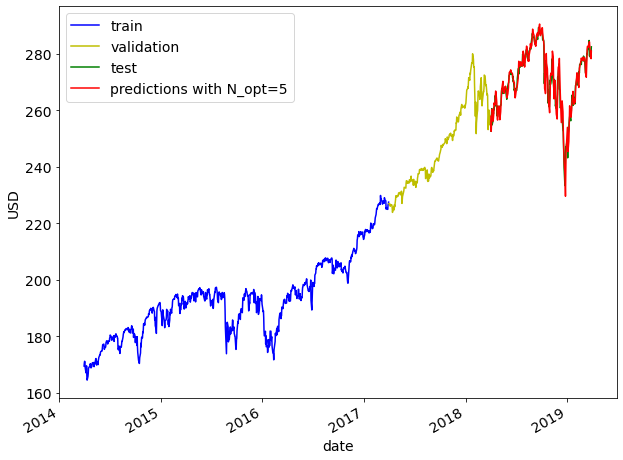

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-')
ax = cv.plot(x='date', y='adj_close', style='y-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

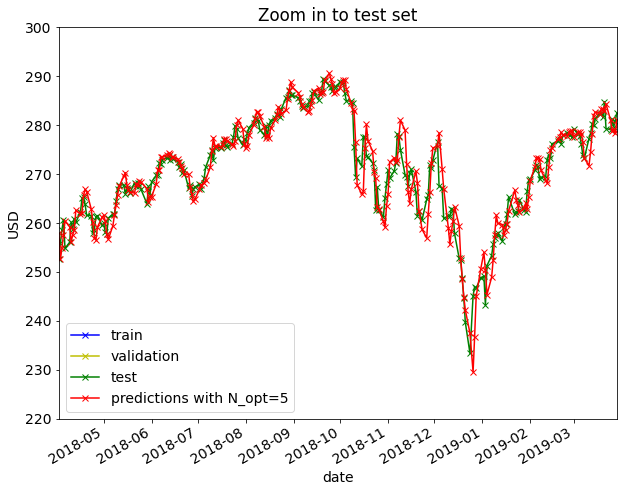

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8  # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-')
ax = cv.plot(x='date', y='adj_close', style='yx-', ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 2), date(2019, 3, 29)])
ax.set_ylim([220, 300])
ax.set_title('Zoom in to test set')

(220.0, 300.0)

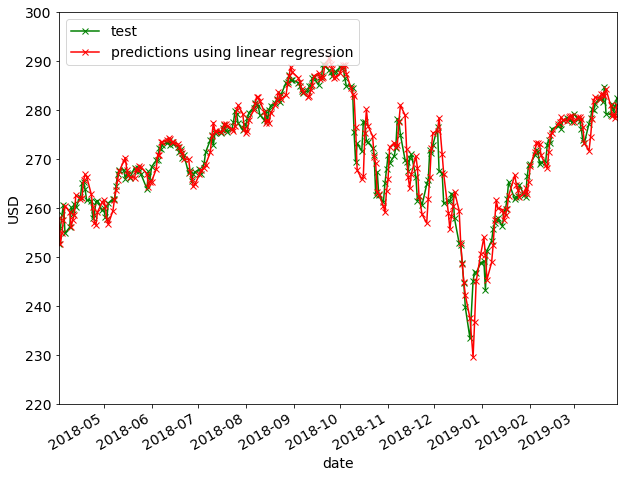

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8  # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-')
ax = test.plot(x='date', y='est_N5', style='rx-', ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 2), date(2019, 3, 29)])
ax.set_ylim([220, 300])

In [ ]:
# Save as csv
test_lin_reg = test
test_lin_reg.to_csv("/content/test_lin_reg.csv")

## Result:
* On the validatiton set, the lowest RMSE is 1.8568 which is achieved using N=1, ie. using value on day t-1 to predict value on day t. And the next lowest RMSE is 2.1317, which is achieved using N=5, ie. using values from days t-5 to t-1 to predict value on day t. So we will use N_opt=5 in this work since our aim here is to use linear regression.
* On the test set, the $R^2 = 0.907$, the RMSE is 3.198 and MAPE is 0.862% using N_opt=5